# Data Prep Notebook
This notebook is a scratchpad to test different data preparation functions that will be used in the final pipeline.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from tqdm.notebook import tqdm

In [3]:
# Vader for sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/james/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
mostliked="../data/processed/mostliked_500000.csv"
mostdisliked="../data/processed/mostdisliked_500000.csv"
randompct="../data/processed/random_percent_1.csv"
randompct10=r"/run/user/1000/gvfs/smb-share:server=metebox,share=data/JAMES/datasets/youtube-meta/youtube-02-2019-dump/random_percent_10.csv"
randompctpoint2="../data/processed/random_percent_point2.csv"

In [5]:
comments_liked_path =  "../data/processed/comments_csv/liked_videos_comments_0.csv"
comments_disliked_path = "../data/processed/comments_csv/disliked_videos_comments_0.csv"
comments_randompoint2_path = "../data/processed/comments_csv/randommpoint2_comments_0.csv"

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
random_state = 42

## Loading Video Data

In [7]:
liked=pd.read_csv(mostliked,engine="python")
disliked=pd.read_csv(mostdisliked,engine="python")
randompct_df = pd.read_csv(randompct,engine="python")
randompctpoint2_df = pd.read_csv(randompctpoint2,engine="python")

In [5]:
%%time
randompct_df_10 = pd.read_csv(randompct10,engine="python")

CPU times: user 8min 18s, sys: 46.6 s, total: 9min 5s
Wall time: 10min 4s


In [17]:
# Testing smaller randompct_df by sampling a smaller fraction
randompct_df = randompct_df.sample(frac=0.5).reset_index(drop=True)

### Preparing dataframe for processing

In [18]:
# Liked, disliked, and random
combined_df = pd.concat([liked,disliked,randompct_df])

# Exclude randompct
# combined_df = pd.concat([liked,disliked])

In [19]:
# Shuffle DF
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

## Loading Comments

In [20]:
# Load comment dataframes
comments_liked_df = pd.read_csv(comments_liked_path,lineterminator='\n')
comments_disliked_df = pd.read_csv(comments_disliked_path,lineterminator='\n')

In [21]:
# Concat dataframes together
comments_all_df=pd.concat([comments_liked_df,comments_disliked_df])

In [55]:
# Checking for corrupted video_id if they are longer than 11 characters which is the standard length
comments_all_df[ comments_all_df["video_id"].str.len() > 11 ].head(3)

,cid,text,time,author,channel,votes,heart,video_id,text_cleaned,language,photo


# Preparing Data for Model

In [22]:
# Based on what we can get at inference time from the Youtube API or scraping
X_cols = [
    "duration",
    "age_limit",
    "view_count",
    "like_count",
    "view_like_ratio",
    "is_comments_enabled",
    "is_live_content",
    "cat_codes",
    "desc_neu",
    "desc_neg",
    "desc_pos",
    "desc_compound",
    "comment_neu",
    "comment_neg",
    "comment_pos",
    "comment_compound",
    "votes"
]

y_col = "ld_score_ohe"

# Category codes from the Youtube API
cat_code_dict = {1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

inv_cat_code_dict = {v: k for k, v in cat_code_dict.items()}

In [23]:
def find_english(df,only_eng=True):
    """
    Takes in a dataframe, performs vader sentiment analysis on it and outputs sentiment, and filters for english only.
    """
    df['desc_text'] = df['desc_text'].str.lower()                                                 #Remove capitalization                                            
    df['desc_text'] = df['desc_text'].str.replace('[^\w\s]','')                                   #Removes extra whitespaces
    df['desc_text'] = df['desc_text'].str.replace('@[A-Za-z0-9]+', '')                            #Removes any tags using @
    df['desc_text'] = df['desc_text'].str.replace('\n', '')                                       #Remove newline 

    data=pd.DataFrame((df.desc_text)).astype(str)
    data['scores']=data['desc_text'].apply(SentimentIntensityAnalyzer().polarity_scores)          #Apply Vader Sentiment Analysis

    data['desc_neu']=data['scores'].apply(lambda score_dict: score_dict['neu'])                        #Extract Neutral Values from dictionary
    data['desc_neg']=data['scores'].apply(lambda score_dict: score_dict['neg'])                        #Extract Negative Values from dictionary
    data['desc_pos']=data['scores'].apply(lambda score_dict: score_dict['pos'])                        #Extract Positive Values from dictionary
    data['desc_compound']=data['scores'].apply(lambda score_dict: score_dict['compound'])              #Extract Compound Values from dictionary

    combined_data=pd.concat([df,data], axis=1).reindex(df.index)                    #Add values back to original dataframe
    if only_eng:
        eng_data= combined_data[combined_data['desc_neu'] != 1]                              #Filter out df values with a neu score of 1 (indicate foreign desc)
        return eng_data
    else:
        return combined_data
    
    
def clean_comments(df):
    """
    Takes in comment dataframe and cleans necessary columns and prepares them for sentiment analysis.
    """
    
    df_clean=df[['video_id','votes','text']].copy()                                                #Select necessary columns
    df_clean['text_cleaned'] = df_clean['text'].str.replace('[^\w\s]','')                    #Removes extra whitespaces
    df_clean['text_cleaned'] = df_clean['text_cleaned'].str.replace('@[A-Za-z0-9]+', '')     #Removes any tags using @
    df_clean['text_cleaned'] = df_clean['text_cleaned'].str.replace('\n', '')                #Remove newline punctuation 
    df_clean['text_cleaned'] = df_clean['text_cleaned'].str.lower()                          #Removes Capitalization             

    return df_clean

def comment_sentiment(df_clean):
    """
    Takes in cleaned comment dataframe and performs sentiment analysis on it.
    Groups by video_id using mean and returns the dataframe.
    """
    
    #Designate Sentiment Analyzer
    sid = SentimentIntensityAnalyzer()
    
    #Ensure Text is in string format
    text = df_clean['text_cleaned']
    text = str(text).encode('utf-8')
    
    #Apply Sentiment Analyzer to text data, parse out dictionary value to columns
    df_clean['scores']=df_clean['text_cleaned'].apply(lambda text:sid.polarity_scores(str(text)))
    df_clean['comment_neg']=df_clean['scores'].apply(lambda score_dict: score_dict['neg'])
    df_clean['comment_neu']=df_clean['scores'].apply(lambda score_dict: score_dict['neu'])
    df_clean['comment_pos']=df_clean['scores'].apply(lambda score_dict: score_dict['pos'])
    df_clean['comment_compound']=df_clean['scores'].apply(lambda score_dict: score_dict['compound'])
  
    #Ensure values are in numeric format select necessary columns for analysis 
    df_clean["votes"] = pd.to_numeric(df_clean["votes"], errors='coerce')
    df_comm=df_clean[['video_id','votes','comment_neg','comment_neu','comment_pos','comment_compound']]
  
    #Group dataframe by video ID taking the mean of the comment values
    df_comments_all=df_comm.groupby(['video_id']).mean().reset_index()
  
    return df_comments_all
    
    
def ohe_ld_score(score):
    """
    Converts decimal ld_score into categorical -1,0,1
    """
    if score <= 0.5:
        return -1
    elif score < 0.75:
        return 0
    else:
        return 1
    
def conv_category(cat_name):
    """
    Converts category string to number based on our mapping dict from the youtube api.
    """
    try:
        cat_code = inv_cat_code_dict[cat_name]
    except:
        cat_code = 0
    return cat_code

def prepare_data_for_model(df,only_eng=True):
    """
    Takes in a dataframe and performs processing on it to prepare for model training.
    """
    
    # Select columns we are interested in and replace NaN with 0
    df=df[['id','fetch_date','uploader','upload_date','title','desc_text','category','duration',
                       'age_limit', 'view_count', 'like_count','dislike_count', 'average_rating', 'allow_embed', 
                       'is_crawlable','allow_sub_contrib', 'is_live_content', 'is_ads_enabled','is_comments_enabled',
                       'view_like_ratio', 'view_dislike_ratio','like_dislike_ratio',"dislike_like_ratio"]].replace(np.nan, 0)

    # Convert t,f to 0,1 booleans.
    df.allow_embed=df.allow_embed.map(dict(t=1, f=0))
    df.is_crawlable=df.is_crawlable.map(dict(t=1, f=0))
    df.allow_sub_contrib=df.allow_sub_contrib.map(dict(t=1, f=0))
    df.is_live_content=df.is_live_content.map(dict(t=1, f=0))
    df.is_ads_enabled=df.is_ads_enabled.map(dict(t=1, f=0))
    df.is_comments_enabled=df.is_comments_enabled.map(dict(t=1, f=0))
    df.replace([np.inf, -np.inf], np.nan,inplace=True)

    # Convert category column to pandas category type and then take the code to convert it to a numeric value
    df["category"] = df["category"].astype('category')
#     df["cat_codes"] = df["category"].cat.codes
    df["cat_codes"] = df["category"].apply(conv_category)

    # Create like_dislike_score
    df["ld_score"]=(df.like_count/(df.like_count + df.dislike_count))

    # Convert like_dislike_score into -1,0,1 categories for negative, neutral, and positive
    # These will be our y values for the models
    df["ld_score_ohe"] = df["ld_score"].apply(ohe_ld_score)
    
    # Adds sentiment and filters for english
    df = find_english(df,only_eng=only_eng)

    # Replace NaN with 0s
    df=df.replace(np.nan, 0)
    
    # TODO: Might need to normalize values
    
    # Print out the value counts
    print("ld_score_ohe value counts:")
    print(df["ld_score_ohe"].value_counts())
    print("Dataframe processed")
    
    return df

def create_final_dataframe(comment_df,archive_df):
    """
    Processes comment df and archive df into one merged dataframe.
    
    Returns final merged dataframe
    """
    df_clean= clean_comments(comment_df)
    df_comments_all= comment_sentiment(df_clean)
    df_archive_all= prepare_data_for_model(archive_df,only_eng=True)
    final_df=df_archive_all.merge(
        df_comments_all,
        how="left",
        left_on="id",
        right_on="video_id").replace(np.nan, 0)

    return final_df

def create_training_test_sets(df,X_cols,y_col,random_state=None):
    """
    Takes in a processed dataframe and splits it into appropriate training and test splits.
    """
    X = df[X_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=random_state)
    print("Splits created")
    return X, y, X_train, X_test, y_train,y_test

### Process Commments

In [76]:
comment_df_processed = comment_sentiment(clean_comments(comments_all_df))

/tmp/ipykernel_123148/1056963258.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['text_cleaned'] = df_clean['text'].str.replace('[^\w\s]','')                    #Removes extra whitespaces
/tmp/ipykernel_123148/1056963258.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['text_cleaned'] = df_clean['text_cleaned'].str.replace('@[A-Za-z0-9]+', '')     #Removes any tags using @


In [77]:
comment_df_processed.head()

,video_id,votes,comment_neg,comment_neu,comment_pos,comment_compound
0,---7u8gCbEM,96.80,0.12,0.71,0.17,0.21
1,---UeOKv0bc,1.20,0.01,0.98,0.02,-0.02
2,---aixW4GZc,3.50,0.02,0.98,0.00,-0.06
3,---qlK1dgRw,0.00,0.02,0.63,0.36,0.72
4,---xkRuV5s0,22.60,0.01,0.70,0.29,0.48


### Process Main Dataframes

In [78]:
# Create df for training - testing only the function
training_df = prepare_data_for_model(combined_df)

/tmp/ipykernel_123148/1056963258.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('[^\w\s]','')                                   #Removes extra whitespaces
/tmp/ipykernel_123148/1056963258.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('@[A-Za-z0-9]+', '')                            #Removes any tags using @


KeyError: 'neu'

In [73]:
training_df.columns

Index(['id', 'fetch_date', 'uploader', 'upload_date', 'title', 'desc_text',
       'category', 'duration', 'age_limit', 'view_count', 'like_count',
       'dislike_count', 'average_rating', 'allow_embed', 'is_crawlable',
       'allow_sub_contrib', 'is_live_content', 'is_ads_enabled',
       'is_comments_enabled', 'view_like_ratio', 'view_dislike_ratio',
       'like_dislike_ratio', 'dislike_like_ratio', 'cat_codes', 'ld_score',
       'ld_score_ohe', 'desc_text', 'scores', 'neu', 'neg', 'pos', 'compound'],
      dtype='object')

### Combine comment and archive data

In [ ]:
%%time
# First try manually
final_df_manual=training_df.merge(
    df_comments_all,
    how="left",
    left_on="id",
    right_on="video_id").replace(np.nan, 0)

In [ ]:
final_df_manual.head()

In [24]:
%%time
final_training_df = create_final_dataframe(comment_df=comments_all_df,archive_df=combined_df)

/tmp/ipykernel_482015/3603251303.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['text_cleaned'] = df_clean['text'].str.replace('[^\w\s]','')                    #Removes extra whitespaces
/tmp/ipykernel_482015/3603251303.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['text_cleaned'] = df_clean['text_cleaned'].str.replace('@[A-Za-z0-9]+', '')     #Removes any tags using @
/tmp/ipykernel_482015/3603251303.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('[^\w\s]','')                                   #Removes extra whitespaces
/tmp/ipykernel_482015/3603251303.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('@[A-Za-z0-9]+', '')                            #Removes any

ld_score_ohe value counts:
 1    451213
-1    174447
 0     18097
Name: ld_score_ohe, dtype: int64
Dataframe processed
CPU times: user 23min 32s, sys: 5.35 s, total: 23min 38s
Wall time: 23min 38s


In [26]:
# Take a look at the final_training_df
final_training_df.head()

,id,fetch_date,uploader,upload_date,title,desc_text,category,duration,age_limit,view_count,...,desc_neu,desc_neg,desc_pos,desc_compound,video_id,votes,comment_neg,comment_neu,comment_pos,comment_compound
0,FyDBw6Cq6-4,2019-02-03 05:06:14,ЛюбительМира,2018-11-23,WARFACE: КЛАН ХэвиРэйн МЫ ВОШЛИ В ТОП 10 СЕРВЕ...,поддержка каналаговорящий донат от 20р заказ м...,Gaming,6852,0,3380,...,0.97,0.00,0.03,0.51,0,0.00,0.00,0.00,0.00,0.00
1,qtP8rpMJgt8,2019-02-03 06:28:41,Ale Zayan,2015-01-12,Niño baila loco en Woodstaco Fest 2015,el benjita disfrutando de la música del festiv...,Entertainment,129,0,1794,...,0.80,0.00,0.20,0.49,0,0.00,0.00,0.00,0.00,0.00
2,9Yf2CnUpA8M,2019-02-03 01:24:58,ukissrocket,2010-08-27,[Ep 1] You Know U-Kiss 3/3 (en),rocketboxx presentsback by popular demand is t...,Entertainment,87,0,53708,...,0.73,0.02,0.25,0.95,9Yf2CnUpA8M,0.00,0.04,0.70,0.26,0.48
3,5MP8mhSHsd0,2019-02-03 02:29:58,São Paulo FC,2018-10-23,"CONTRATO RENOVADO: FALA, LUAN | SPFCTV",o são paulo acertou nesta terçafeira 23102018 ...,Sports,160,0,17665,...,0.95,0.04,0.00,-0.30,5MP8mhSHsd0,18.40,0.02,0.98,0.00,-0.06
4,0kZyJexI-Ho,2019-02-03 12:49:02,GodSaw,2010-07-02,Tales of a noob (Gears of War 2 Part 5),the purpose of this is to give different and h...,Gaming,646,0,11,...,0.74,0.08,0.17,0.46,0,0.00,0.00,0.00,0.00,0.00


In [27]:
final_training_df.to_pickle("../data/processed/training_df_small_withcomments.pkl")

### Pickle dataframes

In [29]:
# Create df for training
training_df = prepare_data_for_model(combined_df)

# Save df to pickle file for importing later for model training
training_df.to_pickle("./training_df.pkl")

<ipython-input-28-44ee9ad96353>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('[^\w\s]','')                                   #Removes extra whitespaces
<ipython-input-28-44ee9ad96353>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('@[A-Za-z0-9]+', '')                            #Removes any tags using @


ld_score_ohe value counts:
 1    586922
-1    192134
 0     36138
Name: ld_score_ohe, dtype: int64
Dataframe processed


In [50]:
# Create df for training without removing non-english
training_df_all = prepare_data_for_model(combined_df,only_eng=False)

# Save df to pickle file for importing later for model training
training_df_all.to_pickle("./training_df_all.pkl")

<ipython-input-47-2751b2681ccc>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('[^\w\s]','')                                   #Removes extra whitespaces
<ipython-input-47-2751b2681ccc>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('@[A-Za-z0-9]+', '')                            #Removes any tags using @


ld_score_ohe value counts:
 1    1101855
-1     611983
 0      96476
Name: ld_score_ohe, dtype: int64
Dataframe processed


In [51]:
# Create df for final testing
testing_df = prepare_data_for_model(randompctpoint2_df,only_eng=False)

# Save df to pickle file for importing later for model testing
testing_df.to_pickle("./testing_df.pkl")

<ipython-input-47-2751b2681ccc>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('[^\w\s]','')                                   #Removes extra whitespaces
<ipython-input-47-2751b2681ccc>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('@[A-Za-z0-9]+', '')                            #Removes any tags using @


ld_score_ohe value counts:
 1    120389
-1     22215
 0     19234
Name: ld_score_ohe, dtype: int64
Dataframe processed


In [7]:
# Load dfs from pickle
training_df = pd.read_pickle("./training_df.pkl")
training_df_all = pd.read_pickle("./training_df_all.pkl")
testing_df = pd.read_pickle("./testing_df.pkl")

In [8]:
%%time
# Create big df
training_df_big = prepare_data_for_model(randompct_df_10,only_eng=True)

# Save big df to pickle file
randompct10_pklpath=r"/run/user/1000/gvfs/smb-share:server=metebox,share=data/JAMES/datasets/youtube-meta/youtube-02-2019-dump/randompct_df_10.pkl"
training_df_big.to_pickle(randompct10_pklpath)

/tmp/ipykernel_76879/80028306.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('[^\w\s]','')                                   #Removes extra whitespaces
/tmp/ipykernel_76879/80028306.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('@[A-Za-z0-9]+', '')                            #Removes any tags using @


ld_score_ohe value counts:
 1    2704614
 0     360177
-1     358845
Name: ld_score_ohe, dtype: int64
Dataframe processed
CPU times: user 1h 56s, sys: 17 s, total: 1h 1min 13s
Wall time: 1h 2min 4s


In [9]:
training_df_big.describe()

,duration,age_limit,view_count,like_count,dislike_count,average_rating,allow_embed,is_crawlable,allow_sub_contrib,is_live_content,...,view_dislike_ratio,like_dislike_ratio,dislike_like_ratio,cat_codes,ld_score,ld_score_ohe,neu,neg,pos,compound
count,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,...,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00,3423636.00
mean,791.00,0.06,132184.84,997.55,70.95,4.26,0.98,0.99,0.00,0.04,...,2094.19,22.43,0.36,7.85,0.82,0.69,0.80,0.05,0.14,0.31
std,2054.78,1.03,4149619.99,19936.84,3163.24,0.92,0.13,0.09,0.00,0.19,...,11279.05,44.24,0.79,3.81,0.22,0.65,0.15,0.09,0.14,0.56
min,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,-1.00
25%,141.00,0.00,512.00,8.00,1.00,4.07,1.00,1.00,0.00,0.00,...,231.00,3.38,0.05,5.00,0.77,1.00,0.75,0.00,0.04,-0.15
50%,278.00,0.00,2775.00,31.00,3.00,4.62,1.00,1.00,0.00,0.00,...,813.00,9.67,0.14,6.00,0.91,1.00,0.84,0.02,0.10,0.44
75%,640.00,0.00,13881.00,146.00,9.00,4.85,1.00,1.00,0.00,0.00,...,2148.00,24.92,0.39,12.00,0.96,1.00,0.91,0.07,0.19,0.80
max,182750.00,18.00,2736330730.00,9107134.00,4183775.00,5.00,1.00,1.00,0.00,1.00,...,6399412.00,19121.00,243.00,17.00,1.00,1.00,1.00,1.00,1.00,1.00


In [12]:
# Create smaller df for training
training_df_small = prepare_data_for_model(combined_df)

# Save smaller df to pickle file for importing later for model training
training_df_small.to_pickle("../data/processed/training_df_small.pkl")

/tmp/ipykernel_123148/80028306.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('[^\w\s]','')                                   #Removes extra whitespaces
/tmp/ipykernel_123148/80028306.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_text'] = df['desc_text'].str.replace('@[A-Za-z0-9]+', '')                            #Removes any tags using @


ld_score_ohe value counts:
 1    451234
-1    174331
 0     18034
Name: ld_score_ohe, dtype: int64
Dataframe processed


# Model Training and Testing

In [8]:
def train_model(clf_object,model_name,X_train,y_train,X_test,y_test):
    clf_object.fit(X_train,y_train)
    acc, f1 = test_model_metrics(clf=clf_object,model_name=model_name)
    return clf_object, acc, f1

def test_model_metrics(clf, model_name,X_test,y_test):
    testpreds = clf.predict(X_test)
    acc = accuracy_score(y_test,testpreds)
    
    if len(y_test.unique()) > 2:
        average = "weighted"
    else:
        average = "binary"
        
    f1 = f1_score(y_test,testpreds,average=average)
    print(f"{model_name} metrics:")
    print(f"Accuracy Score: {acc}")
    print(f"F1 score: {f1}")
    return acc,f1

### First testing with a combined df of mostliked and mostdisliked comments evenly distributed 500k each.

In [61]:
X, y, X_train,X_test,y_train,y_test = create_training_test_sets(
    prepare_data_for_model(combined_df),
    X_cols,
    y_col,
    random_state=random_state)

ld_score_ohe value counts:
-1    500000
 1    500000
Name: ld_score_ohe, dtype: int64
Dataframe processed
Splits created


In [66]:
# Dummy
train_model(DummyClassifier(strategy='stratified',random_state=random_state),"Dummy Classifier")

Dummy Classifier metrics:
Accuracy Score: 0.49698
F1 score: 0.49606283435853255


In [67]:
# Logistic Regression
train_model(LogisticRegression(n_jobs=-1,random_state=random_state),"Logistic Regression")

Logistic Regression metrics:
Accuracy Score: 0.99391
F1 score: 0.9938833927584995


In [68]:
# Random Forest
train_model(RandomForestClassifier(random_state=random_state),"Random Forest - Default")

Random Forest - Default metrics:
Accuracy Score: 0.9979
F1 score: 0.9978975190725056


### Second testing the random 1 percent of the full database.

In [69]:
X, y, X_train,X_test,y_train,y_test = create_training_test_sets(
    prepare_data_for_model(randompct_df),
    X_cols,
    y_col,
    random_state=random_state)

ld_score_ohe value counts:
 1    601855
-1    111983
 0     96476
Name: ld_score_ohe, dtype: int64
Dataframe processed
Splits created


In [72]:
# Dummy
train_model(DummyClassifier(strategy='stratified',random_state=random_state),"Dummy Classifier")

Dummy Classifier metrics:
Accuracy Score: 0.5850528186395498
F1 score: 0.584358902313237


In [73]:
# Logistic Regression
train_model(LogisticRegression(n_jobs=-1,random_state=random_state),"Logistic Regression")

Logistic Regression metrics:
Accuracy Score: 0.7511723763451476
F1 score: 0.6604567632114086


In [74]:
# Random Forest
train_model(RandomForestClassifier(random_state=random_state),"Random Forest - Default")

Random Forest - Default metrics:
Accuracy Score: 0.851355020238918
F1 score: 0.8349083036216294


In [9]:
# Random Forest - Training multiple times with different train_test_splits by removing random_state
def train_model_loop(df,X_cols,y_col,clf_object,model_name,random_state,runs=5):
    acc_list = []
    f1_list = []
    for i in tqdm(range(runs)):
        X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
        clf_fitted, acc,f1 = train_model(clf_object,model_name)
        acc_list.append(acc)
        f1_list.append(f1)
    print(f"Average accuracy over {runs} runs: {np.mean(acc_list)}")
    print(f"Average f1 score over {runs} runs: {np.mean(f1_list)}")
    return acc_list,f1_list
        

In [93]:
rf_acc_list,rf_f1_list = train_model_loop(
    df = randompct_df,
    X_cols = X_cols,
    y_col = y_col,
    clf_object = RandomForestClassifier(random_state=42),
    model_name = "Random Forest - Default",
    random_state = None,
    runs = 5)

ld_score_ohe value counts:
 1    601855
-1    111983
 0     96476
Name: ld_score_ohe, dtype: int64
Dataframe processed


Splits created
Random Forest - Default metrics:
Accuracy Score: 0.851355020238918
F1 score: 0.8349083036216294
Splits created
Random Forest - Default metrics:
Accuracy Score: 0.851355020238918
F1 score: 0.8349083036216294
Splits created
Random Forest - Default metrics:
Accuracy Score: 0.851355020238918
F1 score: 0.8349083036216294
Splits created
Random Forest - Default metrics:
Accuracy Score: 0.851355020238918
F1 score: 0.8349083036216294
Splits created
Random Forest - Default metrics:
Accuracy Score: 0.851355020238918
F1 score: 0.8349083036216294

Average accuracy over 5 runs: 0.851355020238918
Average f1 score over 5 runs: 0.8349083036216294


In [10]:
def cross_val_model(df,clf_object,X_cols,y_col,random_state,scoring,cv=5):
    """
    Takes in a df, processes it, and then outputs a cross-validation f1 score.
    Adapted from sklearn docs.
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    scores = cross_val_score(clf_object, X, y, cv=cv,scoring=scoring,verbose=1,n_jobs=-1)
    print(f"{scores.mean():0.2f} {scoring} with a standard deviation of {scores.std():0.2f}")
    return scores

In [105]:
cross_val_scores = cross_val_model(
    df = randompct_df,
    clf_object = RandomForestClassifier(random_state=random_state),
    X_cols = X_cols,
    y_col = y_col,
    random_state = random_state,
    scoring="f1_weighted",
    cv=10)

ld_score_ohe value counts:
 1    601855
-1    111983
 0     96476
Name: ld_score_ohe, dtype: int64
Dataframe processed
Splits created


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  6.2min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.3min finished


0.84 f1_weighted with a standard deviation of 0.00


In [106]:
cross_val_scores_f1_macro = cross_val_model(
    df = randompct_df,
    clf_object = RandomForestClassifier(random_state=random_state),
    X_cols = X_cols,
    y_col = y_col,
    random_state = random_state,
    scoring="f1_macro",
    cv=10)

ld_score_ohe value counts:
 1    601855
-1    111983
 0     96476
Name: ld_score_ohe, dtype: int64
Dataframe processed
Splits created


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  6.4min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.7min finished


0.69 f1_macro with a standard deviation of 0.00


In [107]:
cross_val_scores_f1_micro = cross_val_model(
    df = randompct_df,
    clf_object = RandomForestClassifier(random_state=random_state),
    X_cols = X_cols,
    y_col = y_col,
    random_state = random_state,
    scoring="f1_micro",
    cv=10)

ld_score_ohe value counts:
 1    601855
-1    111983
 0     96476
Name: ld_score_ohe, dtype: int64
Dataframe processed
Splits created


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  5.9min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.4min finished


0.85 f1_micro with a standard deviation of 0.00


#### Random Forest Confusion Matrix

In [11]:
def confusion_matrix_model(df,clf_object,X_cols,y_col,random_state,model_name):
    """
    Takes in a df, processes it, and then outputs a confusion matrix.
    Adapted from sklearn docs: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    clf_object.fit(X_train,y_train)
    
    # Adapted from sklearn docs
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        (f"{model_name} Confusion matrix, without normalization", None),
        (f"{model_name} Normalized confusion matrix", "true"),
    ]
    
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf_object,
            X_test,
            y_test,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

ld_score_ohe value counts:
 1    601855
-1    111983
 0     96476
Name: ld_score_ohe, dtype: int64
Dataframe processed
Splits created
Random Forest Confusion matrix, without normalization
[[ 8073  1164  1902]
 [  804  2778  6240]
 [  410  1525 58136]]
Random Forest Normalized confusion matrix
[[0.72 0.1  0.17]
 [0.08 0.28 0.64]
 [0.01 0.03 0.97]]


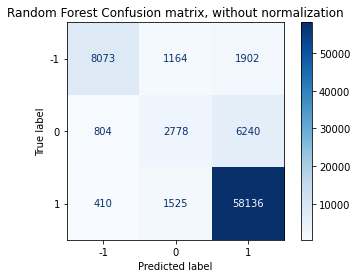

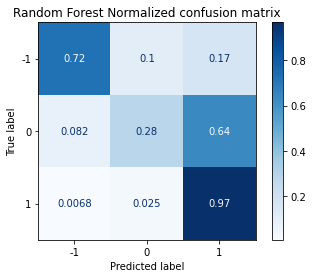

In [11]:
confusion_matrix_model(df=combined_df,
                       clf_object=RandomForestClassifier(random_state=random_state,n_jobs=-1),
                       X_cols=X_cols,
                       y_col=y_col,
                       random_state=random_state,
                       model_name="Random Forest")

### Third testing the random 1 percent of the full database + the most disliked and most liked.

In [35]:
X, y, X_train,X_test,y_train,y_test = create_training_test_sets(
    training_df,
    X_cols,
    y_col,
    random_state=random_state)
# Dummy
train_model(DummyClassifier(strategy='stratified',random_state=random_state),"Dummy Classifier")
# Logistic Regression
train_model(LogisticRegression(n_jobs=-1,random_state=random_state),"Logistic Regression")
# Random Forest
train_model(RandomForestClassifier(n_jobs=-1,random_state=random_state),"Random Forest - Default")

Splits created
Dummy Classifier metrics:
Accuracy Score: 0.5756378802747792
F1 score: 0.574762299333845
Logistic Regression metrics:
Accuracy Score: 0.7963444553483807
F1 score: 0.7650423858237132
Random Forest - Default metrics:
Accuracy Score: 0.9154072620215898
F1 score: 0.902851539088576


(0.9154072620215898, 0.902851539088576)

Splits created
Random Forest Confusion matrix, without normalization
[[16731   269  2307]
 [ 1006   485  2102]
 [ 1109   103 57408]]
Random Forest Normalized confusion matrix
[[0.87 0.01 0.12]
 [0.28 0.13 0.59]
 [0.02 0.   0.98]]


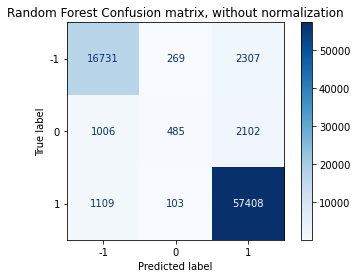

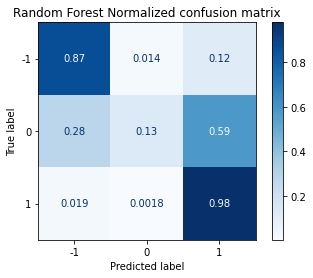

In [36]:
confusion_matrix_model(df=training_df,
                       clf_object=RandomForestClassifier(random_state=random_state,n_jobs=-1),
                       X_cols=X_cols,
                       y_col=y_col,
                       random_state=random_state,
                       model_name="Random Forest")

In [49]:
# Training on only english data, and comparing against final test df

X, y, X_train,X_test,y_train,y_test = create_training_test_sets(
    training_df,
    X_cols,
    y_col,
    random_state=random_state)

rf_clf, acc, f1 = train_model(
    clf_object = RandomForestClassifier(n_jobs=-1,random_state=random_state),
    model_name = "Random Forest - Training",
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test)

testacc,testf1 = test_model_metrics(
    clf=rf_clf,
    model_name="Random Forest - Final Testing",
    X_test=testing_df[X_cols],
    y_test=testing_df[y_col])

Random Forest - Training metrics:
Accuracy Score: 0.9154072620215898
F1 score: 0.902851539088576
Random Forest - Final Testing metrics:
Accuracy Score: 0.832338511350857
F1 score: 0.8071071574339287


RF Confusion Matrix - Trained on Only Eng
[[0.84 0.04 0.12]
 [0.29 0.15 0.56]
 [0.05 0.01 0.94]]


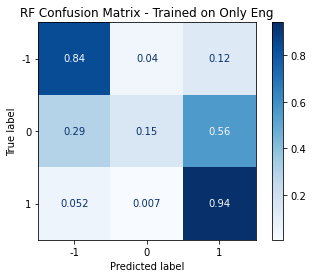

In [56]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix - Trained on Only Eng")

print("RF Confusion Matrix - Trained on Only Eng")
print(disp.confusion_matrix)

In [52]:
# Training on all data, and comparing against final test df

X_all, y_all, X_train_all,X_test_all,y_train_all,y_test_all = create_training_test_sets(
    training_df_all,
    X_cols,
    y_col,
    random_state=random_state)

rf_clf_all, acc, f1 = train_model(
    clf_object = RandomForestClassifier(n_jobs=-1,random_state=random_state),
    model_name = "Random Forest - Training - AllData",
    X_train = X_train_all,
    y_train = y_train_all,
    X_test = X_test_all,
    y_test = y_test_all)

testacc_all,testf1_all = test_model_metrics(
    clf=rf_clf_all,
    model_name="Random Forest - Final Testing - AllData",
    X_test=testing_df[X_cols],
    y_test=testing_df[y_col])

Splits created
Random Forest - Training - AllData metrics:
Accuracy Score: 0.9912904808635917
F1 score: 0.9912014920073301
Random Forest - Final Testing - AllData metrics:
Accuracy Score: 0.8286125631804644
F1 score: 0.8061229967469796


RF Confusion Matrix - Trained on All Rows
[[0.84 0.04 0.12]
 [0.3  0.16 0.54]
 [0.06 0.01 0.93]]


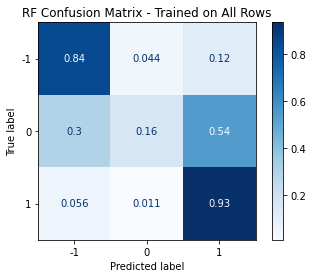

In [57]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf_all,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix - Trained on All Rows")

print("RF Confusion Matrix - Trained on All Rows")
print(disp.confusion_matrix)

In [70]:
len(X_cols)

12

In [76]:
### Testing a manual prediction
manual_pred_input = pd.DataFrame(np.array([1,1,1,1,1,1,1,1,1,1,1,1]).reshape(1, -1),columns=X_cols)
display(manual_pred_input)
print(len(manual_pred_input))
manual_pred = rf_clf.predict(manual_pred_input)
print(manual_pred)

,duration,age_limit,view_count,like_count,view_like_ratio,is_comments_enabled,is_live_content,cat_codes,neu,neg,pos,compound
0,1,1,1,1,1,1,1,1,1,1,1,1


1
[-1]


In [12]:
# Create training and test sets
X_all, y_all, X_train,X_test,y_train,y_test = create_training_test_sets(
    training_df,
    X_cols,
    y_col,
    random_state=random_state)

Splits created


In [ ]:
%%time
# Grid search for Random Forest
# Based on Kaggle tutorial: https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv/notebook

rf_param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,16,32,64],
    'criterion' :['gini', 'entropy']
}

rf_default=RandomForestClassifier(random_state=random_state)
rf_gridcv = GridSearchCV(estimator=rf_default, param_grid=rf_param_grid, cv=10,verbose=10,n_jobs=4,scoring='f1_weighted')
rf_gridcv.fit(X_train, y_train)
rf_best_params = rf_gridcv.best_params_
print("RF Best Params found through grid search cv are:")
print(rf_best_params)

testacc_all,testf1_all = test_model_metrics(
    clf=rf_gridcv,
    model_name="Random Forest - Final Testing - GridSearchBest",
    X_test=testing_df[X_cols],
    y_test=testing_df[y_col])

plot_confusion_matrix(rf_gridcv,testing_df[X_cols],testing_df[y_col],cmap=plt.cm.Blues,normalize="true")

Fitting 10 folds for each of 48 candidates, totalling 480 fits


Fitting 10 folds for each of 6 candidates, totalling 60 fits
RF Best Params found through grid search cv are:
{'max_depth': 8, 'n_estimators': 200}
Random Forest - Final Testing - GridSearchBest metrics:
Accuracy Score: 0.8350016683350017
F1 score: 0.7904982268047801


c:\users\divin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Wall time: 1h 3min 16s


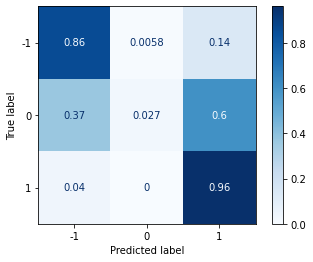

In [18]:
%%time
# Smaller gridsearch
# Grid search for Random Forest
# Based on Kaggle tutorial: https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv/notebook

rf_param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_depth' : [4,8]
}

rf_default=RandomForestClassifier(random_state=random_state)
rf_gridcv = GridSearchCV(estimator=rf_default, param_grid=rf_param_grid, cv=10,verbose=10,n_jobs=4,scoring='f1_macro')
rf_gridcv.fit(X_train, y_train)
rf_best_params = rf_gridcv.best_params_
print("RF Best Params found through grid search cv are:")
print(rf_best_params)

testacc_rf_gridcv,testf1_rf_gridcv = test_model_metrics(
    clf=rf_gridcv,
    model_name="Random Forest - Final Testing - GridSearchBest",
    X_test=testing_df[X_cols],
    y_test=testing_df[y_col])

plot_confusion_matrix(rf_gridcv,testing_df[X_cols],testing_df[y_col],cmap=plt.cm.Blues,normalize="true")

In [16]:
testf1_rf_gridcv

0.7904982268047801

#### Testing GBM

In [93]:
# Create lightGBM dataset
X, y, X_train,X_test,y_train,y_test = create_training_test_sets(
    training_df,
    X_cols,
    y_col,
    random_state=random_state)

gbm_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=random_state)

gbm_model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
             verbose=20,eval_metric='logloss')

Splits created
[20]	training's multi_logloss: 0.256099	valid_0's multi_logloss: 0.254223
[40]	training's multi_logloss: 0.226399	valid_0's multi_logloss: 0.225188
[60]	training's multi_logloss: 0.221283	valid_0's multi_logloss: 0.22101
[80]	training's multi_logloss: 0.219314	valid_0's multi_logloss: 0.220113
[100]	training's multi_logloss: 0.224381	valid_0's multi_logloss: 0.231296


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [96]:
testacc_gbm,testf1_gbm = test_model_metrics(
    clf=gbm_model,
    model_name="GBM - Final Testing",
    X_test=testing_df[X_cols],
    y_test=testing_df[y_col])

GBM - Final Testing metrics:
Accuracy Score: 0.84760068710686
F1 score: 0.8224424477806689


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

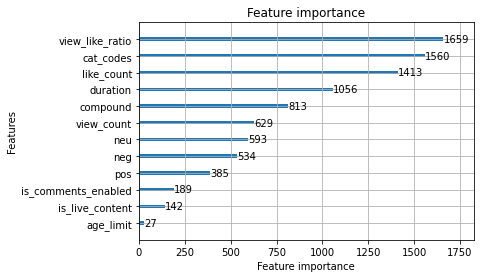

In [97]:
lgb.plot_importance(gbm_model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

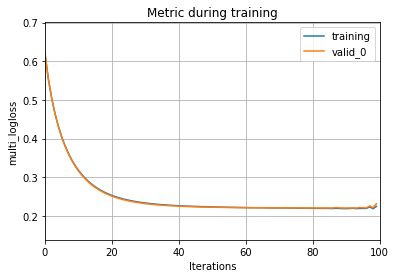

In [98]:
lgb.plot_metric(gbm_model)

c:\users\divin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


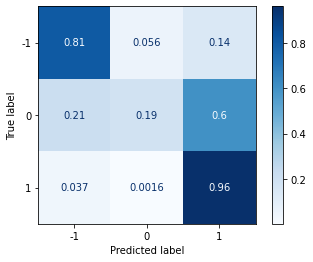

In [102]:
plot_confusion_matrix(gbm_model,testing_df[X_cols],testing_df[y_col],cmap=plt.cm.Blues,normalize="true")

#### GridSearch LGBM

In [104]:
#Define the parameters
# From towardsdatascience tutorial: https://towardsdatascience.com/hyper-parameter-tuning-in-python-1923797f124f
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}

gbm_obj = lgb.LGBMClassifier()
gbm_clf=GridSearchCV(gbm_obj,parameters,scoring='f1_weighted')
gbm_clf.fit(X=X_train, y=y_train)
print(gbm_clf.best_params_)
gbm_predicted=gbm_clf.predict(X_test)
print('Classification of the result on 10% test of training is:')
print(f1_score(y_test, gbm_predicted,average="weighted"))

gbm_predicted_testingdf=gbm_clf.predict(testing_df[X_cols])
print('Classification of the result on testing set is:')
print(f1_score(testing_df[y_col], gbm_predicted_testingdf,average="weighted"))

end = time.time()
print('Execution time is:')
print(end - start)

{'learning_rate': 0.05, 'max_depth': 20, 'min_child_samples': 15, 'num_leaves': 100, 'reg_alpha': 0.03}
Classification of the result on 10% test of training is:
0.9046791163404839
Classification of the result on testing set is:
0.8217566831732137


NameError: name 'time' is not defined

In [105]:
gbm_best_parms = {'learning_rate': 0.05, 'max_depth': 20, 'min_child_samples': 15, 'num_leaves': 100, 'reg_alpha': 0.03}

### Splitting random percent 1 csv into smaller files
This can help us do the comment scraping faster

In [92]:
randompct_df.describe()

,row_id,duration,age_limit,view_count,like_count,dislike_count,average_rating,view_like_ratio,view_dislike_ratio,like_dislike_ratio,dislike_like_ratio
count,810314.00,810314.00,810314.00,810314.00,810314.00,810314.00,810314.00,810225.00,810314.00,810314.00,810314.00
mean,42603487.08,735.13,0.06,93545.55,653.95,48.81,4.09,inf,2197.15,18.40,0.44
std,23890119.63,1912.44,1.05,3161305.89,15951.70,1396.85,1.10,NaN,16943.59,36.72,0.92
min,443.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,22728807.00,120.00,0.00,419.00,6.00,1.00,3.86,32.04,207.00,2.67,0.07
50%,42937633.00,251.00,0.00,2426.00,22.00,2.00,4.52,98.41,810.87,7.60,0.18
75%,63157447.50,596.00,0.00,11891.00,98.00,7.00,4.80,288.42,2236.82,20.00,0.50
max,83437063.00,95594.00,18.00,1258240965.00,6541185.00,658991.00,5.00,inf,11305456.00,3125.00,169.00


In [93]:
random_df_list = np.array_split(randompct_df,8)

In [96]:
random_df_list[0].describe()

,row_id,duration,age_limit,view_count,like_count,dislike_count,average_rating,view_like_ratio,view_dislike_ratio,like_dislike_ratio,dislike_like_ratio
count,101290.00,101290.00,101290.00,101290.00,101290.00,101290.00,101290.00,101281.00,101290.00,101290.00,101290.00
mean,67825835.13,745.78,0.06,100256.87,781.59,59.50,4.09,inf,2290.93,18.37,0.44
std,2936996.88,1972.66,1.05,1154721.01,11239.71,1083.35,1.09,NaN,14622.77,35.86,0.95
min,62750321.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,65289460.75,121.00,0.00,425.00,6.00,1.00,3.86,32.00,206.00,2.69,0.07
50%,67824091.00,251.00,0.00,2432.50,22.00,2.00,4.52,98.29,815.00,7.67,0.18
75%,70359167.75,594.00,0.00,12101.00,100.00,8.00,4.80,289.50,2264.38,20.00,0.50
max,83116912.00,48987.00,18.00,68232859.00,2266507.00,239370.00,5.00,inf,2012613.00,1514.00,81.00


In [97]:
for i, d in enumerate(random_df_list):
    d_csv_path = f"../data/processed/randompct1split_{i}.csv"
    d.to_csv(d_csv_path)

In [100]:
"filename".split(".")[0]

'filename'

In [99]:
"filename.csv".split(".")

['filename', 'csv']